# 動画・画像処理レッスン３
## 画像処理・解析の全自動化
by 石川晃平(aka konkon)  
e-mail: ishikawa@unno.material.nagoya-u.ac.jp

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import random
import os
import glob

# HomCloudのインターフェース
# 使うときはコメントアウトを外す
#import homcloud.interface as hc  

from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy import ndimage as ndi
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from tqdm import tqdm_notebook as tqdm

In C:\Users\velve\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\velve\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\velve\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## 動画の読み込み

In [2]:
movie_path = '../0.5%2.5μmPS_100Hz_8Vp-p_short_doublespeed.avi'
cap = cv2.VideoCapture(movie_path) # 動画パスを入力
framerate = cap.get(cv2.CAP_PROP_FPS) # フレームレート
count = cap.get(cv2.CAP_PROP_FRAME_COUNT) # フレーム数
print(framerate,count)

29.97002997002997 7207.0


## 動画から何フレームおきに画像を読み込むかを選択

In [3]:
skip_length = 30 # 30フレーム(約1秒)ごとに画像を読み込み
frame_numbers = np.arange(0,int(count),skip_length)
print(frame_numbers.shape)

(241,)


## 関数の定義

In [4]:
#画像を正規化する関数
def normalize(img):
    hoge = img.copy()
    max_, min_ = np.max(hoge), np.min(hoge)
    fuga = (hoge - min_)/(max_ - min_)
    return fuga

#極座標変換
def CalcPolarCoordinates(pts):
    pts_polar = np.array([i - pts[0] for i in pts])[1:]
    pts_polar = np.array([[np.sqrt(i[1]**2 + i[0]**2), np.arctan2(i[0],i[1])] for i in pts_polar])
    return pts_polar

#秩序変数を計算する関数
def CalcOrderParam(theta,order):
    num = theta.shape[0]
    cosine = np.sum(np.cos(order*theta)) / num
    sine = np.sum(np.sin(order*theta)) / num
    psi = np.sqrt(cosine**2 + sine**2)
    return psi

## 保存用ディレクトリの作成

In [5]:
try:
    os.mkdir('./detect')
except:
    print('Directory for perticle detection already exist.')
    
try:
    os.mkdir('./phom')
except:
    print('Directory for persistent homology already exist.')

Directory for perticle detection already exist.
Directory for persistent homology already exist.


## 全自動解析
基本的にはレッスン2でやったことをfor文で回しているだけです。  
パーシステントホモロジーの計算がなければ、4～5 iteration/secぐらいで進むはずです。

In [6]:
# 拡大後の画像サイズをここで設定
size = 600

# Homcloudでパーシステントホモロジーの計算をするときはここをTrueに。
# その場合は環境設定を忘れずに。
calcHomology = False

##-----------------ここから追記部分------------------##

# 生の画像を一時保存するリスト
images_raw = []

# 画像処理の結果を一時保存するリスト
images_results = []

# 秩序変数の配列を一時保存するリスト
order_list = []

# 結合粒子数の配列を一時保存するリスト
connections_list = []

##-----------------ここまで追記部分------------------##

for num in tqdm(frame_numbers):
    
    # 動画からの画像読み込み
    cap.set(cv2.CAP_PROP_POS_FRAMES, num)
    ret,frame = cap.read()
    # 画像のトリミング
    img = frame[60:310,250:500]
    # 規定サイズへの画像の拡大
    img = cv2.resize(img,(size,size), interpolation=cv2.INTER_CUBIC)
    # グレースケール変換
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # 輝度の正規化
    img_norm = (normalize(img)*255).astype(np.uint8)
    
    ##-----------------ここから追記部分------------------##
    images_raw.append(img_norm)
    ##-----------------ここまで追記部分------------------##
    
    # Non-local means denoisingによるノイズ除去
    img_norm = cv2.fastNlMeansDenoising(img_norm,None,7,11,15)
    # Gaussian filterを用いたスムージング
    img_blur = cv2.GaussianBlur(img_norm,(9,9),0)
    
    # マスクの作成
    __,mask = cv2.threshold(img_blur,30,255,cv2.THRESH_BINARY)
    mask = cv2.erode(mask,np.ones((31,31),np.uint8),iterations = 1)
    __,area = cv2.threshold(img_blur,200,255,cv2.THRESH_BINARY_INV)
    area[np.where(mask == 0)] = 0
    
    # 適応的二値化
    th = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,-3)
    # 領域検出
#     cnts,__ = cv2.findContours(th,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    # OpenCVのバージョンが古くてここでエラーが出る場合は下のように戻り値を変える
    __,cnts,__ = cv2.findContours(th,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    # 検出領域のフィルタリング
    pts_filtered = []
    for cnt in cnts:
        M = cv2.moments(cnt)
        if(M['m00'] != 0):
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            x,y,w,h = cv2.boundingRect(cnt)
            aspect_ratio = np.log10(float(w)/h)
            a = float(cv2.contourArea(cnt))
            extent = a /(w*h)
            if(aspect_ratio > -0.1 and aspect_ratio < 0.4 and extent > 0.2 and area[cy,cx] != 0 and a > 1):
                pts_filtered.append([cy,cx])
            else:
                pass
        else:
            pass
    pts_filtered = np.array(pts_filtered).T
    
    # 近傍粒子の検出と二重検出のフィルタリング
    nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(pts_filtered.T)
    distances, indices = nbrs.kneighbors(pts_filtered.T)
    
    center_list = []
    idx_rem = []
    for d,i in zip(distances,indices):
        i = i[np.where(d < 7)]
        pts = pts_filtered.T[i]
        idx_rem.extend(i[1:])
        if(i[0] not in idx_rem):   
            center = np.median(pts,axis=0)
            center_list.append(center)
    center_list = np.array(center_list).astype(np.int32)
    
    #重複削除
    center_list = np.unique(center_list,axis=0)
    center_list = center_list.T
    
    #近傍粒子数の計算
    nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(center_list.T)
    distances, indices = nbrs.kneighbors(center_list.T)
    
    # 秩序変数の計算
    psi_list = []
    for dist,idx in zip(distances,indices):
        pts = center_list.T[idx[np.where(dist < 22)]]
        pts_polar = CalcPolarCoordinates(pts)
        if(pts_polar.shape[0] > 0):
            psi = CalcOrderParam(pts_polar[:,1],6)
        else:
            psi = 0
        psi_list.append(psi)
        
    ##-----------------ここから追記部分------------------##
    order_list.append(np.array(psi_list))
    ##-----------------ここまで追記部分------------------##
    
    psi_list = np.array(psi_list)*256
    psi_color = cv2.applyColorMap(psi_list.astype(np.uint8), cv2.COLORMAP_COOL)
    
    # 近接粒子数と結合を計算
    co_list = []
    connections = []
    for d,i in zip(distances,indices):
        idx = i[np.where(d < 22)][1:]
        co_list.append(idx.shape[0])
        for j in idx:
            connections.append([center_list.T[i[0]],center_list.T[j]])
    co_list = np.array(co_list)
    
    ##-----------------ここから追記部分------------------##
    connections_list.append(co_list)
    ##-----------------ここまで追記部分------------------##
    
    connections = np.array(connections)
    
    # 検出結果と秩序変数をプロット
    img_res = cv2.cvtColor(img_norm,cv2.COLOR_GRAY2BGR)
    for con in connections:
        img_res = cv2.line(img_res,(con[0][1],con[0][0]),(con[1][1],con[1][0]),(255,255,255),1)
    for p_num,cnt in enumerate(center_list.T):
        img_res = cv2.circle(img_res,(cnt[1],cnt[0]),4,tuple([int(x) for x in psi_color[p_num][0]]),-1)
        
    ##-----------------ここから追記部分------------------##
    img_res = cv2.cvtColor(img_res,cv2.COLOR_BGR2RGB)
    images_results.append(img_res)
    ##-----------------ここまで追記部分------------------##
    
#     cv2.imwrite('./detect/'+str(num).zfill(4)+'.png',img_res)
    
#     # ここからはパーシステントホモロジー計算
#     if(calcHomology):
    
#         pointcloud = center_list.T/size
#         hc.PDList.from_alpha_filtration(pointcloud, save_to="pointcloud.idiagram",save_boundary_map=True)
#         pdlist = hc.PDList("pointcloud.idiagram")
#         pd1 = pdlist.dth_diagram(1)
        
#         min_,max_ = 0, 2e-3

#         fig=plt.figure(facecolor='white',dpi=150)
#         ax = fig.add_subplot(111)
#         ax.set_aspect('equal', adjustable='box')
#         H = ax.hist2d(pd1.births, pd1.deaths,bins=75,range=[[min_,max_],[min_,max_]],
#                       norm=mpl.colors.LogNorm(), cmap="rainbow")
#         L = ax.plot([0,1], [0,1], c="black", lw=1)
#         ax.set_xlabel('Birth')
#         ax.set_ylabel('Death')
#         ax.ticklabel_format(style="sci",axis="y",scilimits=(0,0))
#         ax.ticklabel_format(style="sci",axis="x",scilimits=(0,0))
#         plt.xlim(min_,max_)
#         plt.ylim(min_,max_)
#         pp = fig.colorbar(H[3],ax=ax)
#         pp.mappable.set_clim(1,50)
#         plt.savefig('./phom/'+str(num).zfill(4)+'.png')
#         plt.close(fig)
    
#     else:
#         pass

C:\Users\velve\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## 秩序変数が閾値(th_order)を超えた粒子の割合の時間変化

Text(0, 0.5, 'Ordered Particle Ratio (th = 0.8)')

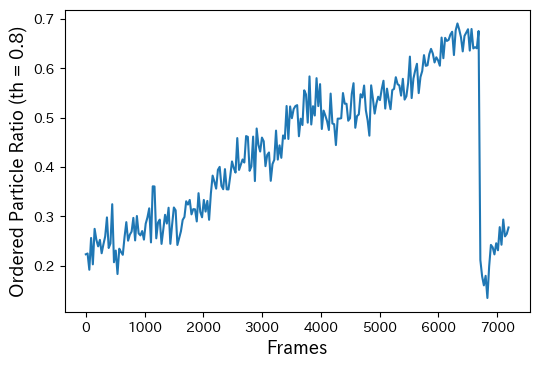

In [7]:
th_order = 0.8
order_particles = [np.where(i > th_order)[0].shape[0]/i.shape[0] for i in order_list]
frame_range = np.arange(1,count,framerate)

fig = plt.figure(dpi=100)
plt.plot(frame_range,order_particles)
plt.xlabel('Frames',fontsize=13)
plt.ylabel('Ordered Particle Ratio (th = '+str(th_order)+')',fontsize=13)

## 近接結合数が閾値(th_connection)を超えた粒子の割合の時間変化

Text(0, 0.5, 'Connected Particle Ratio (th = 3)')

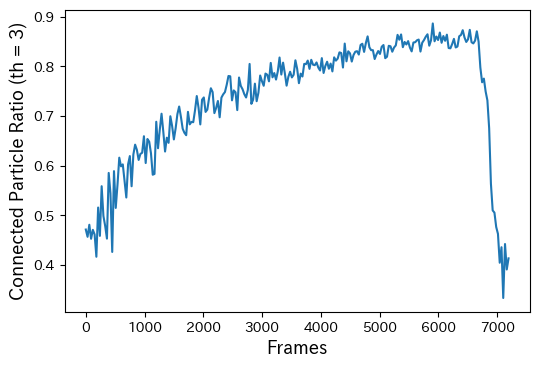

In [8]:
th_connection = 3 # 半結晶位置
connected_particles= [np.where(i > th_connection)[0].shape[0]/i.shape[0] for i in connections_list]
frame_range = np.arange(1,count,framerate)

fig = plt.figure(dpi=100)
plt.plot(frame_range,connected_particles)
plt.xlabel('Frames',fontsize=13)
plt.ylabel('Connected Particle Ratio (th = '+str(th_connection)+')',fontsize=13)

In [9]:
try:
    os.mkdir('./summary')
except:
    print('Directory for perticle detection already exist.')

Directory for perticle detection already exist.


In [12]:
frame_range = np.arange(1,count,framerate)

for n in tqdm(range(len(images_results))):
    fig = plt.figure(figsize=(7,7),dpi=100)
    plt.subplot(221)
    plt.title('Original Image')
    plt.imshow(255-images_raw[n],cmap='Greys')
    plt.subplot(222)
    plt.title('Detection result')
    plt.imshow(images_results[n])
    plt.subplot(223)
    plt.title('Ordered Particles Ratio (th='+str(th_order)+')')
    plt.plot(frame_range[:n],order_particles[:n])
    plt.xlim(-100,count+100)
    plt.ylim(0,0.8)
    plt.subplot(224)
    plt.title('Connected Particle Ratio (th='+str(th_connection)+')')
    plt.plot(frame_range[:n],connected_particles[:n])
    plt.xlim(-100,count+100)
    plt.ylim(0.3,0.92)
    plt.savefig('./summary/frame'+str(n*30).zfill(4)+'.png')
    plt.close()

C:\Users\velve\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for n in tqdm(range(len(images_raw))):
    fig = plt.figure(figsize=(8,8),dpi=150)
    plt.subplot(221)
    plt.title('Original Image')
    plt.imshow(images_raw[n])
    plt.subplot(222)
    plt.title('Detection result')
    plt.imshow(images_nns[n])
    plt.subplot(223)
    plt.title('Coord. Number of Reds')
    plt.plot(list(range(0,7)),red_coords[n][0],'o-',c='red')
    plt.plot(list(range(0,7)),red_coords[n][1],'o-',c='green')
    plt.ylim(0,200)
    plt.subplot(224)
    plt.title('Coord. Number of Greens')
    plt.plot(list(range(0,7)),green_coords[n][0],'o-',c='green')
    plt.plot(list(range(0,7)),green_coords[n][1],'o-',c='red')    
    plt.ylim(0,100)
    plt.savefig('./analysis/001(2)/frame'+str(n*30).zfill(4)+'.png')
    plt.close()